# COMP0197: Diabetes Prediction

This tutorial uses Shapley Values to explain a regression model for diabetes prediction. We will use the diabetes dataset available on Kaggle.

Author: Sophie Martin

Library documentation:
- https://shap.readthedocs.io/en/latest/
- https://github.com/slundberg/shap#citations

In [273]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score


# Explore the dataset

In [274]:
data = pd.read_csv('data/diabetes.csv')

In [275]:
# Check datatypes and empty values 
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


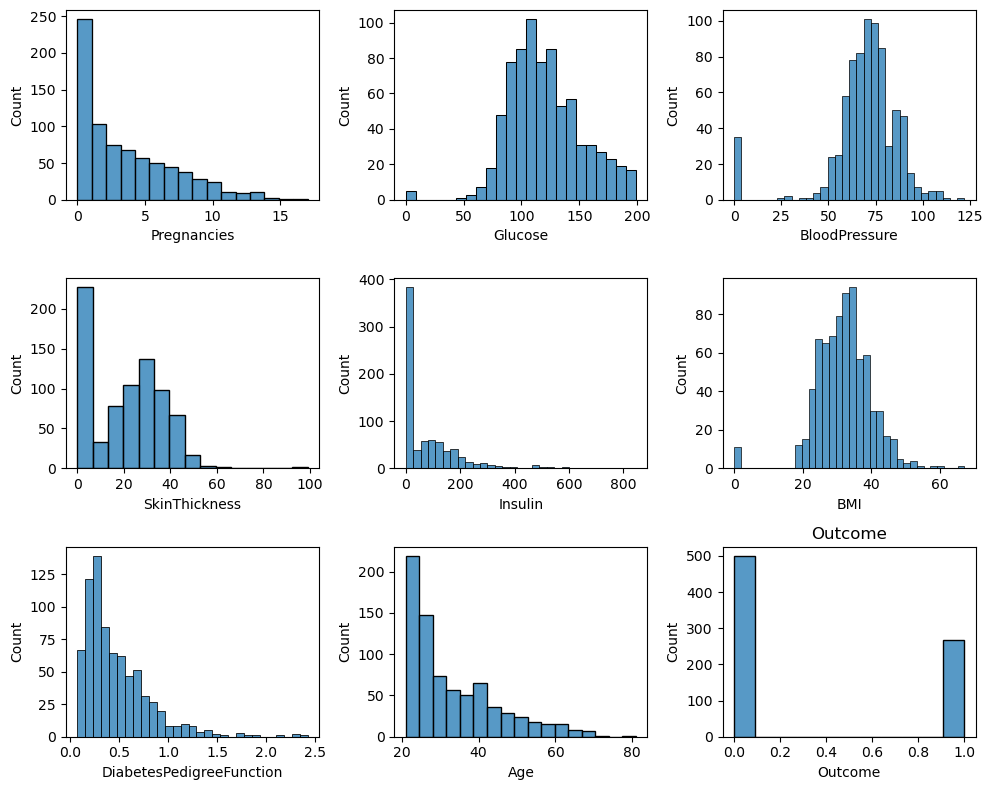

In [276]:
fig, axes = plt.subplots(3, 3, figsize=(10,8))
axes = axes.flatten()
try:
    for i, col in enumerate(data.columns.to_list()):
        sns.histplot(data, x=col, ax=axes[i], label=col)
        plt.title(col)
        plt.tight_layout()
except Exception as e:
    print(col,e)

In [277]:
# Count zero values
(data == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [278]:
# Impute unrealistic values (cannot have zero skin thickness)

data['BMI'].replace(0, np.nan , inplace = True)
data['BloodPressure'].replace(0, np.nan , inplace = True)
data['Insulin'].replace(0, np.nan , inplace = True)
data['Glucose'].replace(0, np.nan , inplace = True)
data['SkinThickness'].replace(0, np.nan , inplace = True)

data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [279]:
# Impute missing values with mean
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data_imputed = pd.DataFrame(imp.fit_transform(data), columns=data.columns)

In [280]:
# Get high-level summaries of data 
data.describe().T.style.background_gradient(cmap='hot_r')

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
Glucose,763.000000,121.686763,30.535641,44.000000,99.000000,117.000000,141.000000,199.000000
BloodPressure,733.000000,72.405184,12.382158,24.000000,64.000000,72.000000,80.000000,122.000000
SkinThickness,541.000000,29.153420,10.476982,7.000000,22.000000,29.000000,36.000000,99.000000
Insulin,394.000000,155.548223,118.775855,14.000000,76.250000,125.000000,190.000000,846.000000
BMI,757.000000,32.457464,6.924988,18.200000,27.500000,32.300000,36.600000,67.100000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000
Outcome,768.000000,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000


In [281]:
data_imputed.describe().T.style.background_gradient(cmap='hot_r')

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
Glucose,768.000000,121.686763,30.435949,44.000000,99.750000,117.000000,140.250000,199.000000
BloodPressure,768.000000,72.405184,12.096346,24.000000,64.000000,72.202592,80.000000,122.000000
SkinThickness,768.000000,29.153420,8.790942,7.000000,25.000000,29.153420,32.000000,99.000000
Insulin,768.000000,155.548223,85.021108,14.000000,121.500000,155.548223,155.548223,846.000000
BMI,768.000000,32.457464,6.875151,18.200000,27.500000,32.400000,36.600000,67.100000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000
Outcome,768.000000,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000


Load data into a dataframe

In [282]:
predictors = pd.DataFrame(data=data_imputed).drop(columns=['Outcome'])
target = data_imputed['Outcome'].values

In [283]:
predictors.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,72.0,35.00000,155.548223,33.6,0.627,50.0
1,1.0,85.0,66.0,29.00000,155.548223,26.6,0.351,31.0
2,8.0,183.0,64.0,29.15342,155.548223,23.3,0.672,32.0
3,1.0,89.0,66.0,23.00000,94.000000,28.1,0.167,21.0
4,0.0,137.0,40.0,35.00000,168.000000,43.1,2.288,33.0


Check target value distribution

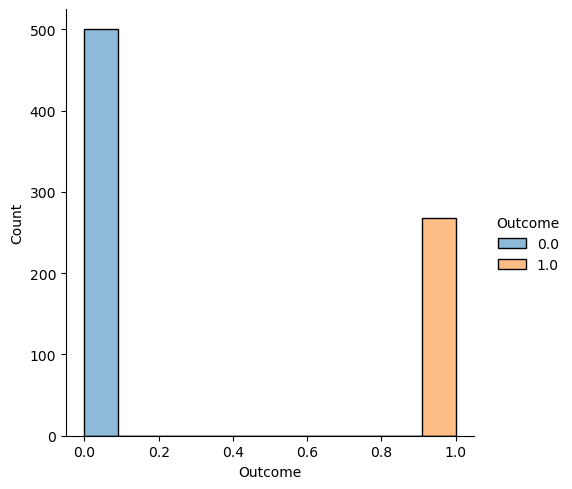

In [284]:
sns.displot(data_imputed, x='Outcome' , kind='hist' , hue='Outcome')
plt.show()

We have some class imbalance.

# Train a model

In [285]:
# Use 80% of the data for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=0)

In [286]:
# Specify model params
params = {
    "n_estimators": 1000,
    "max_depth": 5,
    "min_samples_split": 5,
    "random_state":0,
}

In [287]:
model = GradientBoostingClassifier(**params).fit(x_train, y_train)

In [288]:
model_cv = cross_val_score(model, x_train, y_train, cv=5).mean()
test = model.score(x_test, y_test)
print('Evaluation of the Random Forest performance\n')
print(f'Cross validation score: {model_cv.round(4)}')
print(f'Test score: {test.round(4)}')

Evaluation of the Random Forest performance

Cross validation score: 0.7296
Test score: 0.7792


# Evaluate model

Let's check the performance on the test set

In [289]:
acc = accuracy_score(y_test, model.predict(x_test))
print("The accuracy on test set: {:.4f}".format(acc))

The accuracy on test set: 0.7792


Due to class imbalance, we should also report the AUROC and 

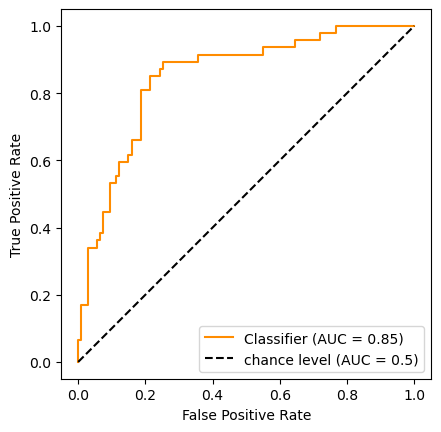

In [290]:
RocCurveDisplay.from_predictions(
    y_test,
    model.predict_proba(x_test)[:,1],
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Let's explain the model using SHAP

In [291]:
shap.initjs()

In [292]:
explainer = shap.Explainer(model)

Explain all examples in the dataset seen during training = **global explanation**

In [293]:
shap_values = explainer(x_train)

In [294]:
shap_values.shape

(614, 8)

In [295]:
x_train.shape

(614, 8)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


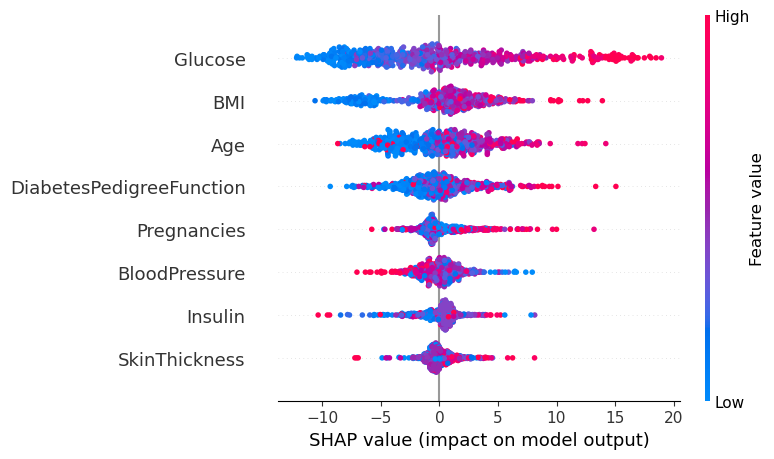

In [296]:
shap.summary_plot(shap_values, features=x_train)

Get mean SHAP values over all training samples

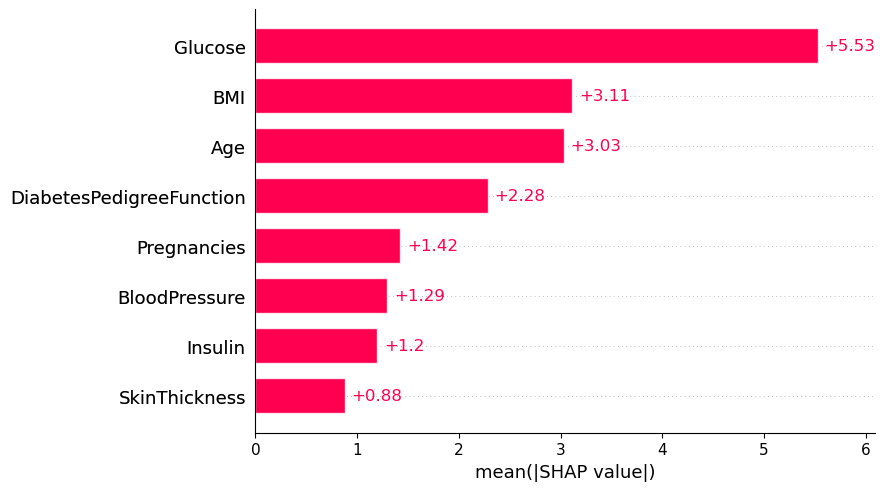

In [297]:
shap.plots.bar(shap_values)

Now take a single test subject and generate a **local explanation**

In [298]:
test_shap = explainer(x_test.iloc[0, :])

In [299]:
f'Actual label: {y_test[0]}, model prediction: {model.predict(x_test)[0]}, probability: {model.predict_proba(x_test)[0,1]:.5f} '

'Actual label: 1.0, model prediction: 1.0, probability: 1.00000 '

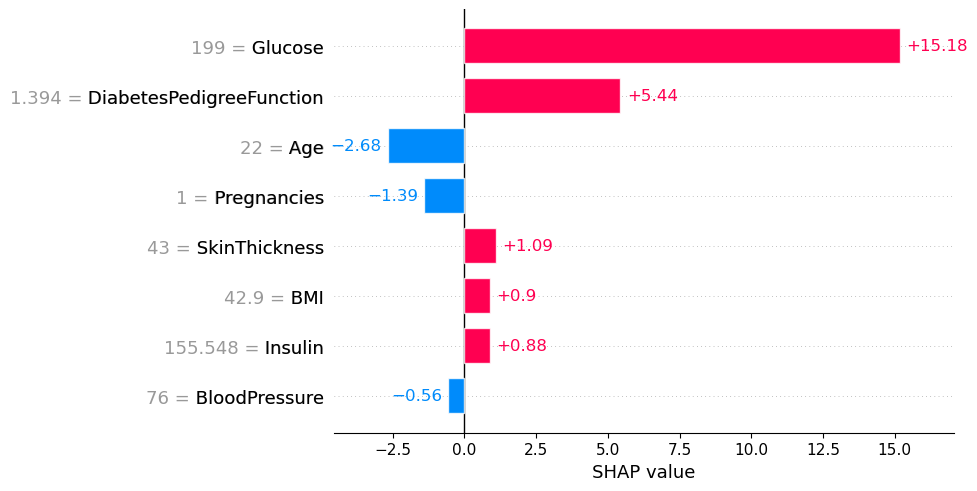

In [300]:
shap.plots.bar(test_shap)

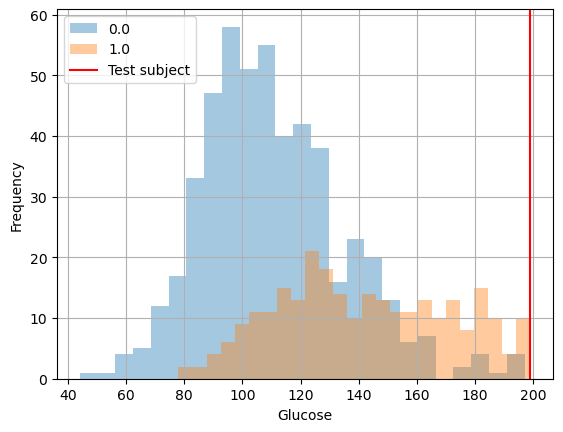

In [301]:
data_imputed.groupby("Outcome").Glucose.hist(alpha=0.4, legend=True, bins=25)
plt.axvline(x=x_test.iloc[0]['Glucose'], label='Test subject', color='r')
plt.legend()
plt.xlabel('Glucose')
plt.ylabel('Frequency')
plt.show()

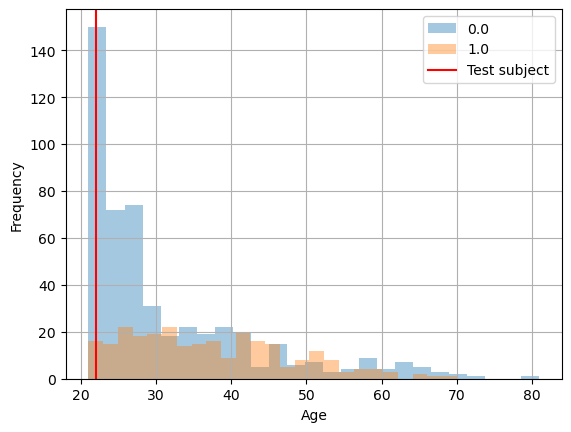

In [302]:
data_imputed.groupby("Outcome").Age.hist(alpha=0.4, legend=True, bins=25)
plt.axvline(x=x_test.iloc[0]['Age'], label='Test subject', color='r')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

This person has a higher than average glucose level, so not surprising this was influencial in the model's decision. Their age was low which had a negative contribution. 